# Setup
## Imports

In [1]:
import os
from os import environ
from os.path import join
import glob
from tqdm import tqdm

import requests
from bs4 import BeautifulSoup

# # geoprocessing imports
import geopandas as gpd
import pandas as pd
import numpy as np

# raster processing imports
import xarray as xr
import rioxarray

# Functions definition

In [2]:
# Functions

## Parameters

In [8]:
# main path
data_folder = '../data'

# paths
aoi_path = join(data_folder, 'admin', 'adm2.geojson')
ghsl_path = join(data_folder, 'ghsl')

# Main code
## Define the AOI

In [9]:
aoi_gdf = gpd.read_file(aoi_path)
aoi_utm_crs = aoi_gdf.estimate_utm_crs()

## Perform zonal stats

In [26]:
from rasterstats import zonal_stats

file_list = glob.glob(os.path.join(ghsl_path, "*.tif"))

# define a model to reproject all the other rasters
df_list = []
for file in tqdm(file_list):
    date = pd.to_datetime(os.path.basename(file)[5:9].replace('.', '-')+'-01', yearfirst=True)

    # open the raster
    da = rioxarray.open_rasterio(file, masked=True)
    
    # Squeeze the band dimension
    if 'band' in da.dims:
        da = da.squeeze('band', drop=True)
    
    # Set nodata
    da = da.rio.write_nodata(np.nan)
    
    # Reproject AOI to match raster CRS
    aoi_reprojected = aoi_gdf.to_crs(da.rio.crs)
    
    # generate the zonal stats
    stats_dict = zonal_stats(
        aoi_reprojected,
        da.values,
        stats=['sum'],
        affine=da.rio.transform(),
        nodata=np.nan,
    )
    stats_df = pd.DataFrame(stats_dict)
    stats_df['month'] = date
    df_list.append(stats_df)

stats_df = pd.concat(df_list).join(aoi_gdf['district']).reset_index(drop=True)
stats_df = stats_df.sort_values(['month', 'district'])

100%|██████████| 2/2 [00:06<00:00,  3.33s/it]


In [27]:
# re-index to add year 2024 to multi-index
stats_monthly_df = stats_df.set_index(['month',"district"])\
                        .reindex([(y, c) for c in stats_df["district"].unique() for y in pd.date_range('2020-01-01', '2025-01-01', freq='1YS')])\
                        .reset_index()

# interpolate population for missing years
stats_monthly_df['sum'] = stats_monthly_df[['month', 'sum']].set_index('month').interpolate(method='linear').reset_index().loc[:, ['sum']]

In [28]:
# export
stats_monthly_df.to_csv(join(data_folder, 'indicators', 'population.csv'))

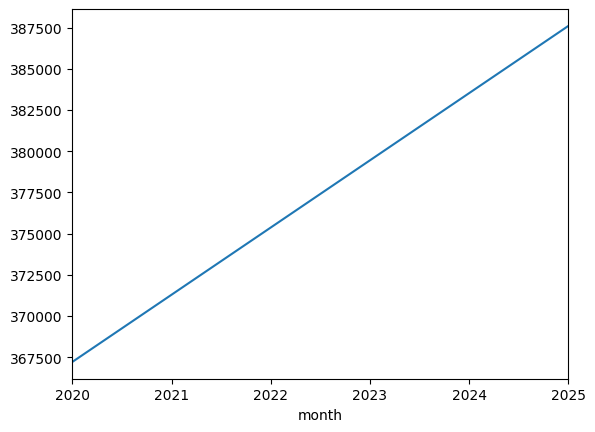

In [29]:
stats_monthly_df[stats_monthly_df['district']=='Northern Buttes District'].set_index('month')['sum'].plot();